# Clash Royale Season 35 - Analysis

This is an analysis for my Clash Royale Season 35 battles, as a log bait player. The goals of the current analysis is:
- Explore patterns of win/defeat and investigate my own win rate of the current season.
- Investigate the trophy change distribution (+ve/-ve) after each battle.
- Explore patterns of win/defeat streaks.
- Finding out the most common cards in my opponents decks.
- Build a Bayesian model to infer distributions for: win rate, positive trophy change and negative trophy change.
- Simulate random walk battles to compare actual progression vs. the simulated battles.

# Part I - Exploratory Analysis

## Library imports & Data wrangling

In [76]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotx
import seaborn as sns
import pymc3 as pm
import arviz as az

plt.style.use(matplotx.styles.gruvbox['dark'])

In [77]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = 'Ubuntu-Medium.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

In [78]:
df = pd.read_csv('data.csv')

In [79]:
df.tail()

,battle_time,team_tag,team_name,team_starting_trophies,team_trophy_change,team_crowns,team_card_1,team_card_2,team_card_3,team_card_4,...,opponent_card_8,opponent_card_1_level,opponent_card_2_level,opponent_card_3_level,opponent_card_4_level,opponent_card_5_level,opponent_card_6_level,opponent_card_7_level,opponent_card_8_level,team_won
472,2022-06-04 05:37:11,#2PLQVY2Y0,Ozymandias,6138,-28,0,Princess,Goblin Barrel,Valkyrie,Inferno Tower,...,Minion Horde,9,9,12,6,9,14,12,14,False
473,2022-06-04 05:34:19,#2PLQVY2Y0,Ozymandias,6109,29,1,Princess,Goblin Barrel,Valkyrie,Inferno Tower,...,Skeleton Army,14,6,6,9,14,12,12,9,True
474,2022-06-04 07:01:59,#2PLQVY2Y0,Ozymandias,6139,28,1,Princess,Goblin Barrel,Valkyrie,Inferno Tower,...,Miner,9,14,11,9,12,4,8,6,True
475,2022-06-04 08:13:46,#2PLQVY2Y0,Ozymandias,6137,31,2,Princess,Goblin Barrel,Valkyrie,Inferno Tower,...,Rocket,14,14,12,9,6,6,14,12,True
476,2022-06-04 08:08:49,#2PLQVY2Y0,Ozymandias,6167,-30,0,Princess,Goblin Barrel,Valkyrie,Inferno Tower,...,Tornado,9,14,12,9,12,9,9,8,False


In [80]:
df['battle_time'] = df['battle_time'].astype('datetime64[ns]')
df['battle_time'] = df['battle_time'] + pd.Timedelta(hours=2)

# set df to season start
df = df[df['battle_time'] >= '2022-05-02 10:05:00']
df = df.sort_values(by='battle_time', ascending=True).reset_index(drop=True)
df.to_csv('data_sorted.csv', index=False)
df.head()

,battle_time,team_tag,team_name,team_starting_trophies,team_trophy_change,team_crowns,team_card_1,team_card_2,team_card_3,team_card_4,...,opponent_card_8,opponent_card_1_level,opponent_card_2_level,opponent_card_3_level,opponent_card_4_level,opponent_card_5_level,opponent_card_6_level,opponent_card_7_level,opponent_card_8_level,team_won
0,2022-05-03 09:58:37,#2PLQVY2Y0,Ozymandias,5609,27,2,Goblin Gang,Inferno Tower,Goblin Barrel,Valkyrie,...,Princess,9,9,14,6,12,6,6,6,True
1,2022-05-03 13:30:23,#2PLQVY2Y0,Ozymandias,5636,-26,0,Goblin Gang,Inferno Tower,Goblin Barrel,Valkyrie,...,Bomber,6,9,14,12,14,12,6,14,False
2,2022-05-03 13:45:14,#2PLQVY2Y0,Ozymandias,5610,30,1,Goblin Gang,Inferno Tower,Goblin Barrel,Valkyrie,...,Mini P.E.K.K.A,9,12,13,12,9,12,11,12,True
3,2022-05-03 21:38:23,#2PLQVY2Y0,Ozymandias,5640,30,1,Goblin Gang,Inferno Tower,Goblin Barrel,Valkyrie,...,Archer Queen,14,14,12,9,9,14,6,4,True
4,2022-05-04 06:47:39,#2PLQVY2Y0,Ozymandias,5670,28,1,Goblin Gang,Inferno Tower,Goblin Barrel,Valkyrie,...,Mortar,12,9,12,5,5,9,5,14,True


## Win/Defeat, Is there a pattern?

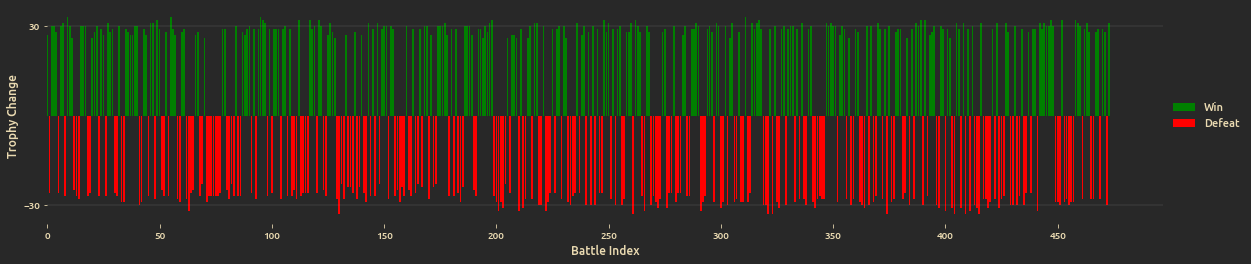

In [81]:
win_loss_df = pd.DataFrame({
    'Win': df.team_trophy_change.where(df.team_trophy_change > 0, np.nan),
    'Defeat': df.team_trophy_change.where(df.team_trophy_change < 0, np.nan),
}).reset_index(drop=True)

#ax = win_loss_df.plot(kind='bar', stacked=True, figsize=(20, 3), color=['green', 'red'], rot=0)
fig = plt.figure(figsize=(20, 4))
ax = plt.axes()
ax.bar(win_loss_df.index, win_loss_df.Win, color='green', label='Win', width=0.75)
ax.bar(win_loss_df.index, win_loss_df.Defeat, color='red', label='Defeat', width=0.75)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, fontsize=11)

for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)


ax.set_xlabel('Battle Index', fontweight='bold', fontsize=12)
ax.set_ylabel('Trophy Change', fontweight='bold', fontsize=12)
ax.set_yticks([-30, 30])
ax.set_xlim(left=0)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(50))

# show horizontal gridlines
ax.grid(which='major', axis='y', linestyle='-', linewidth=0.25, color='grey')

In [82]:
observed_win_rate = df.team_won.astype(int).mean()
print('Overall Observed Win rate: {:.2f}%'.format(observed_win_rate * 100))

Overall Observed Win rate: 51.27%


In [83]:
n_days_so_far = df.battle_time.max() - df.battle_time.min()
print(f'Total Trophy Change since season start = {df["team_trophy_change"].sum()} trophies')
print(f'Total number of battles = {len(df)} battles')
print(f'Active playing days = {n_days_so_far.days} days')
print(f'Avg. rate of trophy increase = {df["team_trophy_change"].sum()/n_days_so_far.days:.2f} trophies/day')

Total Trophy Change since season start = 650 trophies
Total number of battles = 474 battles
Active playing days = 32 days
Avg. rate of trophy increase = 20.31 trophies/day


In [84]:
last_season_end_trophies = 6014

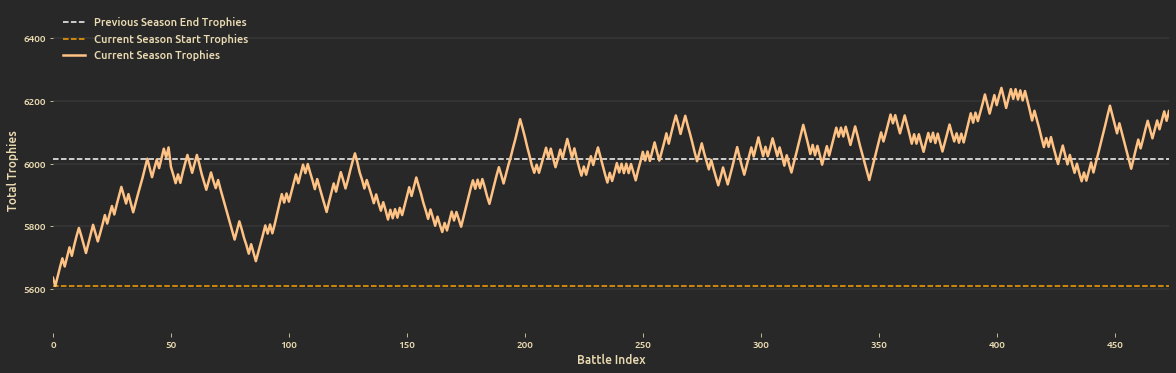

In [153]:
ax = plt.axes()
min_date = df.battle_time.min()
season_starting_trophy = df.team_starting_trophies[df.battle_time == min_date].values[0]

ax.hlines(last_season_end_trophies, xmin=0, xmax=len(df), linewidth=1.5, color='white', linestyles='--', label='Previous Season End Trophies')
ax.hlines(season_starting_trophy, xmin=0, xmax=len(df), linewidth=1.5, color='orange', linestyles='--', label='Current Season Start Trophies')

(df.team_starting_trophies + df.team_trophy_change).reset_index(drop=True).plot(
    kind='line', figsize=(20, 6), label='Current Season Trophies', lw=2.5, ax=ax, color='#ffc285'
)

min_date = df.battle_time.min()
season_starting_trophy = df.team_starting_trophies[df.battle_time == min_date].values[0]


ax.set_xlabel('Battle Index', fontweight='bold', fontsize=12)
ax.set_xticks(np.arange(0, len(df), step=1))
ax.set_xlim(0, len(df) - 1)
ax.set_ylabel('Total Trophies', fontweight='bold', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# show grid
ax.grid(which='major', axis='y', linestyle='-', linewidth=0.25, color='grey')

# show every 5th battle on x-axis labels
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=50))

ax.set_ylim(bottom=season_starting_trophy - 150, top=6500)

# add legend to middle left of plot
plt.legend(frameon=False, fontsize=11, loc='upper left');

## Winning/Losing Streaks, are they the same?

In [86]:
# Calculate count of consecutive wins
win_state = df.team_won.astype(int).values

def count_consecutive_wins(x):
    con_wins = []
    con_losses = []
    current_val = x[0]
    
    i = 0
    while i < len(x):
        count = 0
        while x[i] == current_val:
            i += 1
            count += 1
            if i >= len(x):
                break
        if current_val == 1:
            con_wins.append(count)
        else:
            con_losses.append(count)
        
        if i >= len(x):
            break
        current_val = x[i]
    
    return con_wins, con_losses

con_wins, con_losses = count_consecutive_wins(win_state)

In [87]:
count_consecutive_wins([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1])

([5, 3, 1], [5, 1])

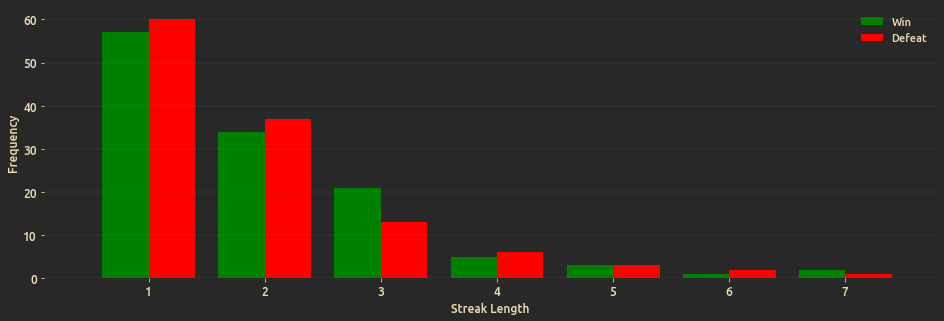

In [88]:
fig, ax = plt.figure(figsize=(16, 5)), plt.axes()
ax.hist(
    [con_wins, con_losses], 
    bins=np.arange(0, max(con_wins) + 2, 1), 
    color=['green', 'red'], 
    align='left', 
    label=['Win', 'Defeat']
)
ax.set_xlabel('Streak Length', fontweight='bold', fontsize=12)
ax.set_ylabel('Frequency', fontweight='bold', fontsize=12)
ax.grid(which='major', axis='y', linestyle='-', linewidth=0.15, color='gray')

for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

x_max = max(max(con_wins), max(con_losses))

ax.set_xlim(left=0.1)
ax.grid(which='major', axis='y', linestyle='-', linewidth=0.15, color='grey')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(frameon=False, loc='upper right', fontsize=11);


In [89]:
max(con_wins), max(con_losses)

(7, 7)

## Opponents' Most Common Cards

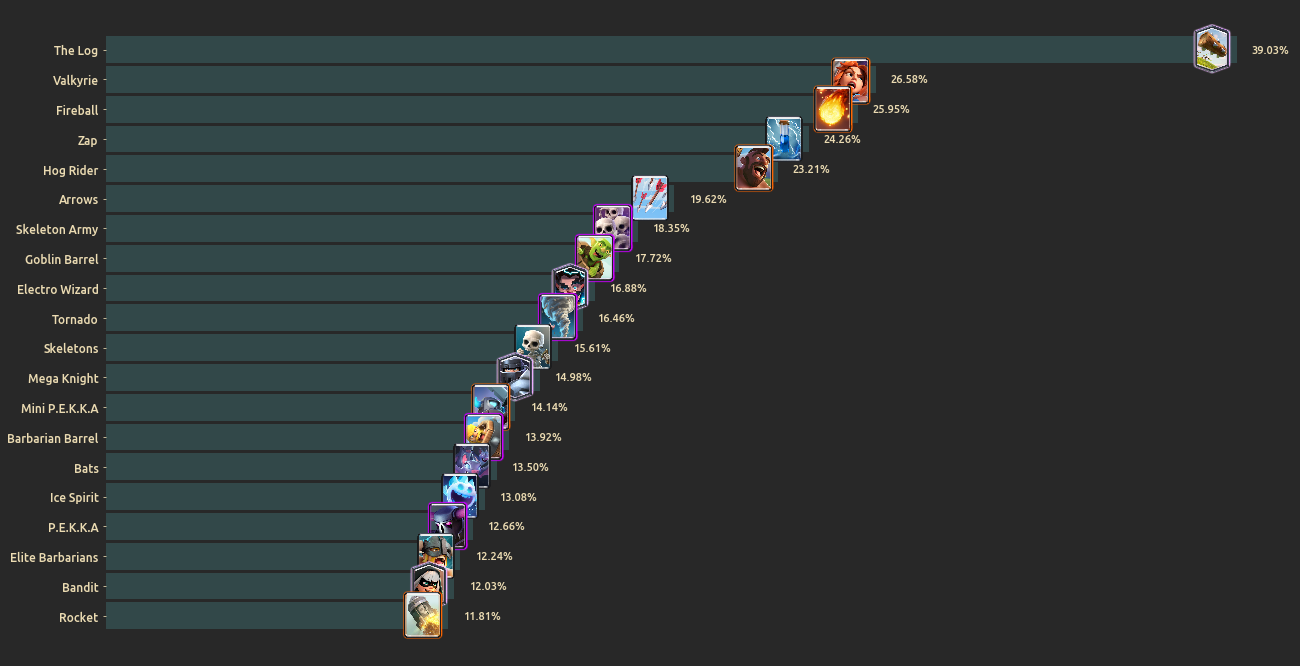

In [90]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Most common cards in games that ended in a defeat
n_common = 20
columns = [f'opponent_card_{i}' for i in range(1, 9)]
opponent_common_cards = pd.Series(df[columns].values.flatten())
series = opponent_common_cards.value_counts().sort_values(ascending=False)[:n_common]
labels, values = series.index, series.values
values = values / len(df)

fig = plt.figure(figsize=(22, 12))
ax = plt.axes()

def offset_image(x, y, label, bar_is_too_short, ax):
    img = plt.imread(f'cards/{label}.png')
    im = OffsetImage(img, zoom=0.15)
    im.image.axes = ax
    x_offset = -25
    if bar_is_too_short:
        x = 0
    ab = AnnotationBbox(im, (x, y), xybox=(x_offset, 0), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)
    ax.add_artist(ab)

height = 0.9
ax.barh(y=labels, width=values, height=height, align='center', alpha=0.35)

max_value = values.max()
for i, (label, value) in enumerate(zip(labels, values)):
    offset_image(value, i, label, bar_is_too_short=value < max_value / 10, ax=ax)

# add value next to each bar
for i, v in enumerate(ax.patches):
    ax.text(v.get_width() + 0.005, v.get_y() + v.get_height() / 2,
            s=f'{values[i] * 100:.2f}%', ha='left', va='center', fontstyle='italic', fontsize=11)

# Turn off axis lines and ticks of the big subplot
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xticks([])
ax.invert_yaxis()
ax.tick_params(axis='y', labelsize=12)
#plt.title(f"Opponents' Most Common Cards - Top {n_common}", fontweight='bold');
plt.subplots_adjust(left=0.15)

# Part II - Bayesian Inference and Simulation

## Win Rate Inference

We assume that each battle outcome is independent and identically distributed (I believe that this is not a valid assumption, but we will test how plausible this assumption), we also assume a uniform distribution of the win rate, and we try to infer the win rate posterior distribution under the assumption of a Bernoulli likelihood.

Prior:
$$ p(\alpha) \sim \text{Uniform}(0,1) $$

Likelihood:
$$ p(\text{win}|\alpha) \sim \text{Bernoulli}(\alpha)$$

## Trophy Change Distribution

How much trophies do we expect to win/lose after each battle? to answer this we model the observed trophy change (27, 29, 29, 30, .., 33) as a Catenary distribution with a Drichlet prior, for both the positive and negative change.

Prior:
$$ p_+ \sim \text{Dirichlet}([1, \dots, 1]) $$
$$ p_- \sim \text{Dirichlet}([1, \dots, 1]) $$

Likelihood:
$$ \text{Trophy}_+ \sim \text{Categorical}(p_+) $$
$$ \text{Trophy}_- \sim \text{Categorical}(p_-) $$


### Observed Trohpy change - Win case

In [91]:
win_trophies_change = df[df.team_trophy_change > 0].team_trophy_change.reset_index(drop=True)
unique_win_trophies = win_trophies_change.sort_values().unique()
unique_win_trophies_map = {trophies: i for i, trophies in enumerate(unique_win_trophies)}
unique_win_trophies_map_inverse = {v: k for k, v in unique_win_trophies_map.items()}

# replace trophy change with index
win_trophies_change = win_trophies_change.map(unique_win_trophies_map)

### Observed Trohpy Change - Defeat case

In [92]:
loss_trophies_change = df[df.team_trophy_change < 0].team_trophy_change.abs().reset_index(drop=True)
unique_loss_trophies = loss_trophies_change.sort_values().unique()
unique_loss_trophies_map = {trophies: i for i, trophies in enumerate(unique_loss_trophies)}
unique_loss_trophies_map_inverse = {v: k for k, v in unique_loss_trophies_map.items()}

# replace trophy change with index
loss_trophies_change = loss_trophies_change.map(unique_loss_trophies_map)

## Model

In [93]:
with pm.Model() as win_pct_model:
    alpha = pm.Uniform('alpha', lower=0, upper=1.0)
    win_obs_data = pm.Data('win_obs_data', df.team_won.astype('int'))
    win_obs = pm.Bernoulli('win_obs', p=alpha, observed=win_obs_data)
    w_pct_trace = pm.sample(draws=2000, return_inferencedata=True, tune=1000)

with pm.Model() as trophy_change_win_model:
    p_pos = pm.Dirichlet('p_pos', a=np.ones(len(unique_win_trophies)))
    cat_pos_data = pm.Data('cat_pos_data', win_trophies_change)
    cat_pos = pm.Categorical('cat_pos', p=p_pos, observed=cat_pos_data)
    win_trophy_trace = pm.sample(1000, return_inferencedata=True)

with pm.Model() as trophy_change_loss_model:
    p_neg = pm.Dirichlet('p_neg', a=np.ones(len(unique_loss_trophies)))
    cat_neg_data = pm.Data('cat_neg_data', loss_trophies_change)
    cat = pm.Categorical('cat_neg', p=p_neg, observed=cat_neg_data)
    
    loss_trophy_trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_pos]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_neg]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


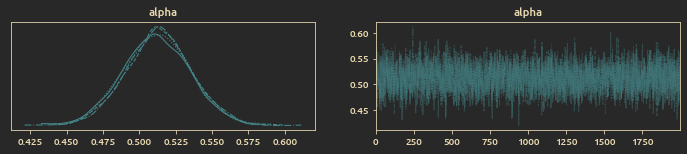

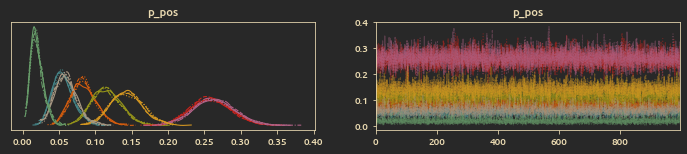

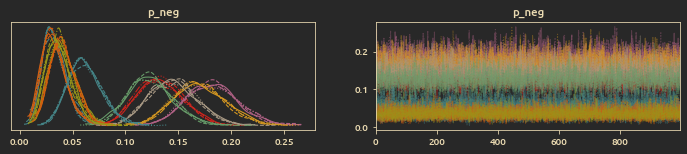

In [94]:
az.plot_trace(w_pct_trace)
az.plot_trace(win_trophy_trace)
az.plot_trace(loss_trophy_trace);

<AxesSubplot:title={'center':'alpha'}>

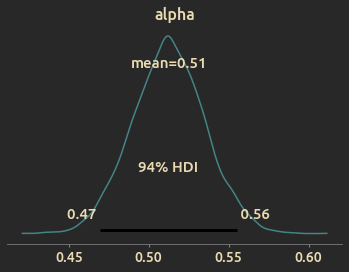

In [95]:
az.plot_posterior(w_pct_trace, var_names=['alpha'])

In [96]:
pm.summary(w_pct_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.512,0.023,0.469,0.555,0.0,0.0,3320.0,5593.0,1.0


In [97]:
summary_df_pos = pm.summary(win_trophy_trace)
summary_df_neg = pm.summary(loss_trophy_trace)

# add column to summary_df
summary_df_pos['trophy_change'] = unique_win_trophies_map.keys()
summary_df_neg['trophy_change'] = unique_loss_trophies_map.keys()
summary_df_pos.sort_values(by='mean', ascending=False, inplace=True)
summary_df_neg.sort_values(by='mean', ascending=False, inplace=True)

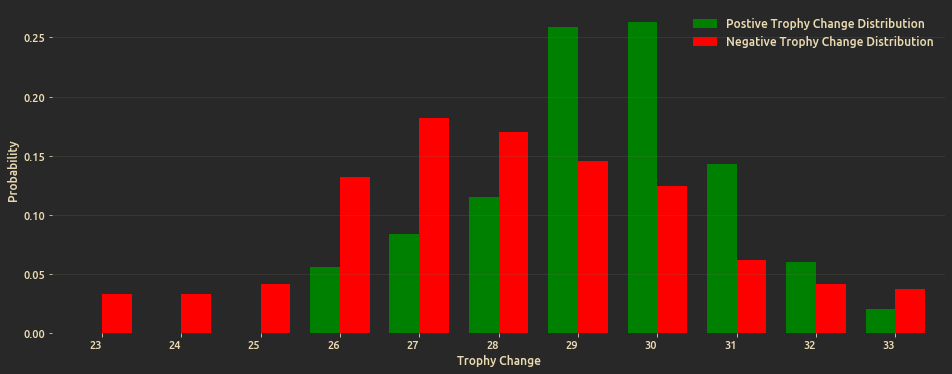

In [98]:
trophy_change_dict = dict.fromkeys(range(23, 34), np.nan)

pos_trophy_change_mean_posterior = trophy_change_dict.copy()
pos_trophy_change_mean_posterior.update(dict(zip(summary_df_pos.trophy_change.to_list(), summary_df_pos['mean'].to_list())))
neg_trophy_change_mean_posterior = trophy_change_dict.copy()
neg_trophy_change_mean_posterior.update(dict(zip(summary_df_neg.trophy_change.to_list(), summary_df_neg['mean'].to_list())))

trophy_change_df = pd.DataFrame(
    {
        'Postive Trophy Change Distribution': pos_trophy_change_mean_posterior.values(),
        'Negative Trophy Change Distribution': neg_trophy_change_mean_posterior.values(),
    },
    index=np.arange(23, 34)
)

ax = trophy_change_df.plot(
    kind='bar', 
    figsize=(16, 6), 
    legend=True,
    color=['green', 'red'],
    width=0.75,
)

ax.set_ylabel('Probability', fontsize=12)
ax.set_xlabel('Trophy Change', fontsize=12)

ax.grid(axis='y', alpha=0.25)

# increase ticks font size
ax.tick_params(labelsize=11)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.legend(fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right");

For me the game was on average more rewarding than it was punishing. I was able to win more trophies than I lost, mode of positive trophy change is 30 while for negative trophy change it's 27, so despite the low win rate, the game on average is rewarding.

## How valid is the assumption that battle outcomes are independent?

I don't think each battle outcome is independent, but if we proceeded anyway to assume that, and given the data we have, is this a valid assumption?
In order to test this we define a Test statistic as the number of switches between wins and defeats.

In [99]:
# calculate number of switches between 0 and 1 in data
def n_switches(data):
    switches = 0
    for i in range(len(data)-1):
        if data[i] != data[i+1]:
            switches += 1
    return switches

data_obs = df.team_won.astype('int').values
T_obs_nswitches = n_switches(data_obs)

In [100]:
n_samples = 20_000

ppc = pm.sample_posterior_predictive(
    trace=w_pct_trace,
    samples=n_samples,
    model=win_pct_model,
    var_names=['win_obs'],
)

In [101]:
# This is our Test statistic, defined as the number of switches between 0 and 1
T_nswitches = np.zeros(shape=(len(ppc['win_obs']),))
T_max_win_streak = np.zeros(shape=(len(ppc['win_obs']),))
T_max_lose_streak = np.zeros(shape=(len(ppc['win_obs']),))
T_autocorr_lag_1 = np.zeros(shape=(len(ppc['win_obs']),))

for i, row in enumerate(ppc['win_obs']):
    T_nswitches[i] = n_switches(row)
    con_wins, con_losses = count_consecutive_wins(row)
    T_max_win_streak[i] = max(con_wins)
    T_max_lose_streak[i] = max(con_losses)
    
    x_t = np.array(row)
    T_autocorr_lag_1[i] = np.corrcoef(x_t[:-1], x_t[1:])[0, 1]


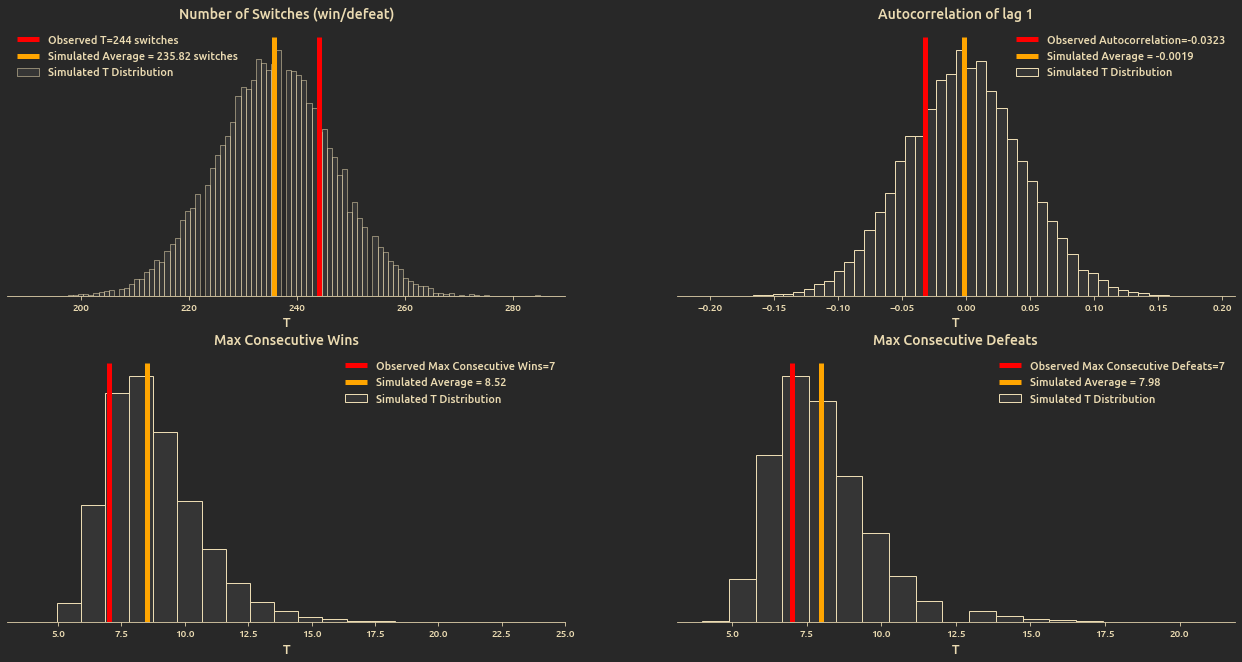

In [102]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22, 11))

# Number of switches
curr_ax = ax[0, 0]
sns.histplot(T_nswitches, bins=100, label='Simulated T Distribution', alpha=0.15, color='gray', ax=curr_ax)
max_y = curr_ax.get_ylim()[1]
curr_ax.vlines(n_switches(data_obs), 0, max_y,label=f'Observed T={T_obs_nswitches} switches', linewidth=5, color='red')
curr_ax.vlines(T_nswitches.mean(), 0, max_y, label=f'Simulated Average = {T_nswitches.mean():.2f} switches', linewidth=5, color='orange')
curr_ax.set_xlabel('T', fontsize=13)
curr_ax.set_title(
    #f'Number of Switches - p-value = {np.count_nonzero(T_nswitches >= T_obs_nswitches)/len(T_nswitches):.2f}',
    'Number of Switches (win/defeat)', 
    fontsize=14,
)

# Autocorrelation
curr_ax = ax[0, 1]
sns.histplot(T_autocorr_lag_1, bins=50, label='Simulated T Distribution', alpha=0.15, color='gray', ax=curr_ax)
max_y = curr_ax.get_ylim()[1]
autocorr_obs = np.corrcoef(data_obs[:-1], data_obs[1:])[0, 1]
curr_ax.vlines(autocorr_obs, 0, max_y,label=f'Observed Autocorrelation={autocorr_obs:.4f}', linewidth=5, color='red')
curr_ax.vlines(T_autocorr_lag_1.mean(), 0, max_y, label=f'Simulated Average = {T_autocorr_lag_1.mean():.4f}', linewidth=5, color='orange')
curr_ax.set_xlabel('T', fontsize=13)
curr_ax.set_title(
    #f'Autocorrelation of lag 1 - p-value = {np.count_nonzero(T_autocorr_lag_1 >= autocorr_obs)/len(T_autocorr_lag_1):.2f}',
    f'Autocorrelation of lag 1',
    fontsize=14,
)
# Max win streak
curr_ax = ax[1, 0]
sns.histplot(T_max_win_streak, bins=len(np.unique(T_max_win_streak)) + 1, label='Simulated T Distribution', alpha=0.15, color='gray', ax=curr_ax)
max_y = curr_ax.get_ylim()[1]
max_cons_wins_obs = max(count_consecutive_wins(data_obs)[0])
curr_ax.vlines(max_cons_wins_obs, 0, max_y,label=f'Observed Max Consecutive Wins={max_cons_wins_obs}', linewidth=5, color='red')
curr_ax.vlines(T_max_win_streak.mean(), 0, max_y, label=f'Simulated Average = {T_max_win_streak.mean():.2f}', linewidth=5, color='orange')
curr_ax.set_xlabel('T', fontsize=13)
curr_ax.set_title(
    #f'Max Consecutive Wins - p-value = {np.count_nonzero(T_max_win_streak >= max_cons_wins_obs)/len(T_max_win_streak):.2f}',
    f'Max Consecutive Wins',
    fontsize=14,
)

# Max lose streak
curr_ax = ax[1, 1]
sns.histplot(T_max_lose_streak, bins=len(np.unique(T_max_lose_streak)) + 1, label='Simulated T Distribution', alpha=0.15, color='gray', ax=curr_ax)
max_y = curr_ax.get_ylim()[1]
max_cons_defeat_obs = max(count_consecutive_wins(data_obs)[1])
curr_ax.vlines(max_cons_defeat_obs, 0, max_y,label=f'Observed Max Consecutive Defeats={max_cons_defeat_obs}', linewidth=5, color='red')
curr_ax.vlines(T_max_lose_streak.mean(), 0, max_y, label=f'Simulated Average = {T_max_lose_streak.mean():.2f}', linewidth=5, color='orange')
curr_ax.set_xlabel('T', fontsize=13)
curr_ax.set_title(
    #f'Max Consecutive Defeats - p-value = {np.count_nonzero(T_max_lose_streak >= max_cons_defeat_obs)/len(T_max_lose_streak):.2f}',
    f'Max Consecutive Defeats',
    fontsize=14,
)

# Turn off spines in all subplots
for ax_ in ax.flatten():
    ax_.spines['right'].set_visible(False)
    ax_.spines['top'].set_visible(False)
    ax_.spines['left'].set_visible(False)
    ax_.set_ylabel('')
    ax_.set_yticks([])
    ax_.legend(fontsize=11)

ax[0, 0].legend(loc='upper left', fontsize=11);

# Simulate random walk battles, since season start

In [103]:
n_samples = 5000
# Sample from win rate posterior predictive distribution
ppc_win = pm.sample_posterior_predictive(
    trace=w_pct_trace,
    samples=n_samples,
    model=win_pct_model,
    var_names=['win_obs']
)
ppc_win_data = ppc_win['win_obs']
raw_result = ppc_win_data.copy()

win_mask = ppc_win_data == 1
n_win = np.count_nonzero(win_mask)

loss_mask = ppc_win_data == 0
n_loss = np.count_nonzero(loss_mask)

# Sample from win trophy change posterior predictive distribution
ppc_win_trophy_change = pm.sample_posterior_predictive(
    trace=win_trophy_trace, 
    samples=math.ceil(n_win/len(win_trophies_change)), 
    model=trophy_change_win_model, 
    var_names=['cat_pos']
)
ppc_win_trophy_chage_data = pd.Series(ppc_win_trophy_change['cat_pos'].flatten()).map(unique_win_trophies_map_inverse).values

# Sample from loss trophy change posterior predictive distribution
ppc_loss_trophy_change = pm.sample_posterior_predictive(
    trace=loss_trophy_trace, 
    samples=math.ceil(n_loss/len(loss_trophies_change)), 
    model=trophy_change_loss_model, 
    var_names=['cat_neg']
)
ppc_loss_trophy_chage_data = pd.Series(ppc_loss_trophy_change['cat_neg'].flatten()).map(unique_loss_trophies_map_inverse).values

# Convert 1/0 results to positive and negative trophy changes
ppc_win_flat = ppc_win_data.flatten()
ppc_win_flat[ppc_win_flat == 1] = ppc_win_trophy_chage_data[:n_win]
ppc_win_flat[ppc_win_flat == 0] = -ppc_loss_trophy_chage_data[:n_loss]
ppc_win_data = ppc_win_flat.reshape(n_samples, -1)

# Only visualize random walks with similar observed win rate
mask = np.abs(raw_result.mean(axis=1) - np.ones(shape=(n_samples,)) * observed_win_rate) < 0.02

c:\Users\maema\Anaconda3\envs\pymc_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [104]:
simulated_trophies = np.hstack(
    [
        np.ones((n_samples, 1)) * season_starting_trophy,
        ppc_win_data
    ]
)

simulated_trophies = np.cumsum(simulated_trophies, axis=1)
mean_trophies = simulated_trophies.mean(axis=0)

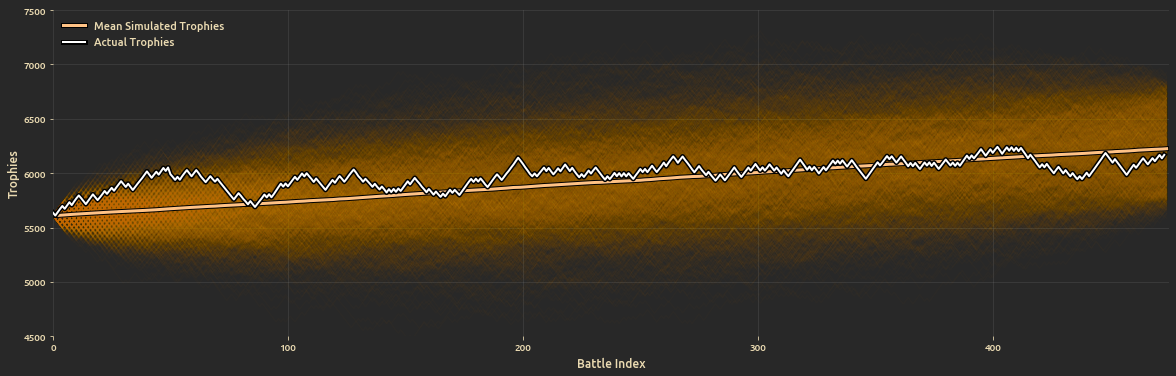

In [105]:
plt.plot(
    np.arange(0, simulated_trophies.shape[1]), 
    simulated_trophies[mask].T, 
    color='orange', 
    alpha=0.015
)

plt.plot(
    np.arange(0, simulated_trophies.shape[1]), 
    mean_trophies, 
    color='#ffc285', 
    label='Mean Simulated Trophies', 
    lw=3,
    path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()]
    )

(df.team_starting_trophies + df.team_trophy_change).reset_index(drop=True).plot(
    kind='line', color='white', label='Actual Trophies', lw=2,
    path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()],
    figsize=(20, 6)
)

# add orange line label to legend
plt.legend(loc='upper left', frameon=True, fontsize=11)

# hide top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# show grid
plt.grid(which='major', axis='x', linestyle='-', color='grey', alpha=0.25)
plt.grid(which='major', axis='y', linestyle='-', color='grey', alpha=0.25)

plt.xlim([0, simulated_trophies.shape[1]])
plt.ylim([4500, 7500])

plt.xlabel('Battle Index', fontweight='bold', fontsize=12)
plt.ylabel('Trophies', fontweight='bold', fontsize=12);

## Predict season ending trophy, based on half season battles

In [106]:
season_trophies = (df.team_starting_trophies + df.team_trophy_change).reset_index(drop=True).values
first_half_idx = np.arange(0, season_trophies.shape[0]//2)
second_half_idx = np.arange(season_trophies.shape[0]//2, season_trophies.shape[0])
first_half_trophies = season_trophies[:len(season_trophies)//2]
second_half_trophies = season_trophies[len(season_trophies)//2:]

In [107]:
with pm.Model() as linear_reg_model:
    theta0 = pm.Normal('theta0', mu=season_starting_trophy, sd=50)
    theta1 = pm.Normal('theta1', mu=0, sd=2)
    sigma = pm.HalfNormal('sigma', 10)
    
    data = pm.Data(
        'data', 
        first_half_idx
    )
    
    mu = theta0 + (theta1 * data)
    y_obs = pm.Normal('y_obs', mu=mu, sd=sigma, observed=first_half_trophies)
    
    trace_lr = pm.sample(4000, tune=2000, return_inferencedata=True, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, theta1, theta0]


Sampling 2 chains for 2_000 tune and 4_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


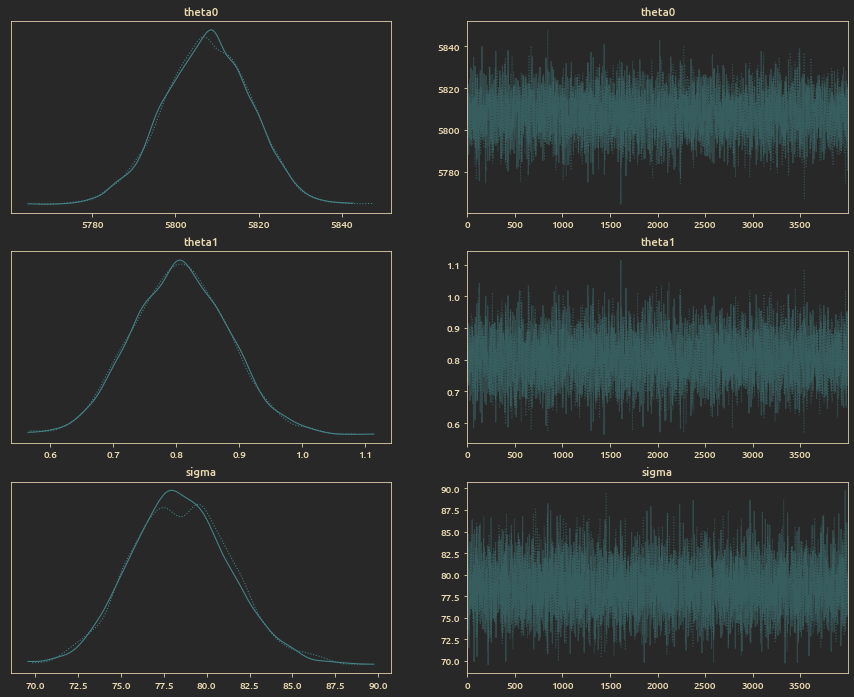

In [108]:
az.plot_trace(trace_lr, var_names=['theta0', 'theta1', 'sigma'], figsize=(15, 12));

In [109]:
ppc_first_half = pm.sample_posterior_predictive(
    trace=trace_lr,
    samples=4000,
    model=linear_reg_model,
)

c:\Users\maema\Anaconda3\envs\pymc_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [110]:
with linear_reg_model:
    pm.set_data({'data': second_half_idx})
    ppc_second_half = pm.sample_posterior_predictive(samples=3000, trace=trace_lr)

c:\Users\maema\Anaconda3\envs\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
c:\Users\maema\Anaconda3\envs\pymc_env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


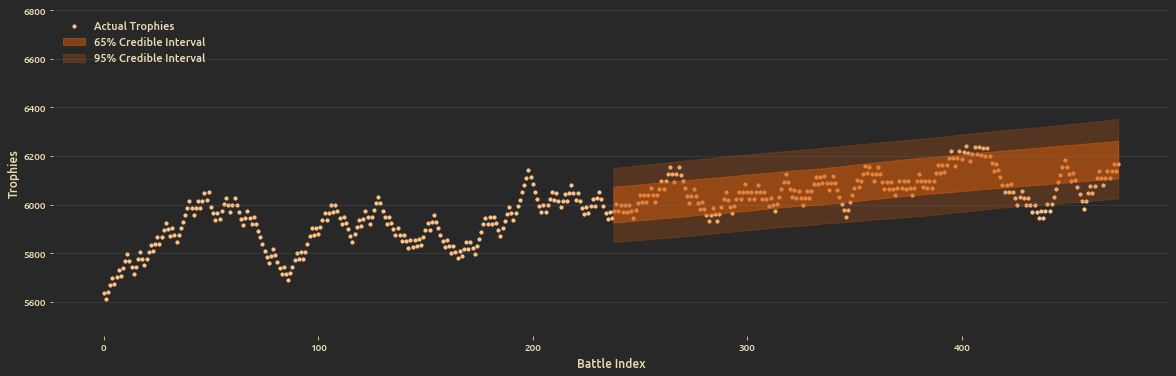

In [146]:
fig = plt.figure(figsize=(20, 6))
plt.ylim([season_starting_trophy - 150, 6800])
plt.scatter(np.arange(0, len(df)), season_trophies, color='#ffc285', label='Actual Trophies', s=10)

az.plot_hdi(second_half_idx, ppc_second_half['y_obs'], hdi_prob=0.65, smooth=True, fill_kwargs={"label": "65% Credible Interval"})
az.plot_hdi(second_half_idx, ppc_second_half['y_obs'], hdi_prob=0.95, smooth=True, fill_kwargs={"label": "95% Credible Interval", 'alpha': 0.25})

# Turn of spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.xlabel('Battle Index', fontweight='bold', fontsize=12)
plt.ylabel('Trophies', fontweight='bold', fontsize=12)



# show grid
plt.grid(which='major', axis='y', linestyle='-', color='grey', alpha=0.25)
plt.legend(loc='upper left', fontsize=11);

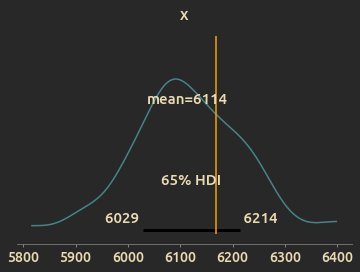

In [112]:
az.plot_posterior(ppc_second_half['y_obs'][-1,:], hdi_prob=0.65)
plt.vlines(x=season_trophies[-1], ymin=0, ymax=0.005, color='orange')

In [113]:
season_trophies[-1]

6168

## Testing the probability of a particular observed losing streak

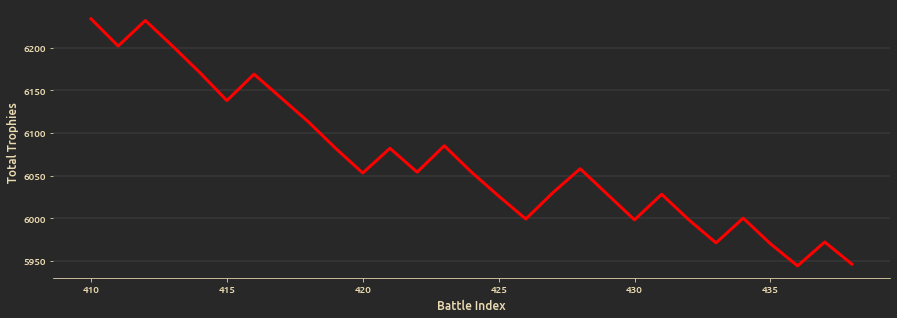

In [114]:
lose_streak_df = df.iloc[410:439, :].copy()
#lose_streak_df.index = np.arange(409, 439)

ax = plt.axes()

(lose_streak_df.team_starting_trophies + lose_streak_df.team_trophy_change).plot(
    kind='line', figsize=(15, 5), label='Current Season Trophies', lw=3, ax=ax, color='red'
)


ax.set_xlabel('Battle Index', fontweight='bold', fontsize=12)
ax.set_ylabel('Total Trophies', fontweight='bold', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

# show grid
ax.grid(which='major', axis='y', linestyle='-', linewidth=0.25, color='grey')

In [115]:
lose_streak_w_pct = lose_streak_df.team_won.sum() / lose_streak_df.team_won.count()
print(f'Observed win percentage: {lose_streak_w_pct * 100:.2f}% in {len(lose_streak_df)} battles.')

Observed win percentage: 34.48% in 29 battles.


In [116]:
# Infer win percentage just before observing the losing streak
with pm.Model() as lose_streak_model:
    alpha_ = pm.Uniform('alpha_', lower=0, upper=1.0)
    win_obs_ = pm.Bernoulli('win_obs_', p=alpha_, observed=df.team_won.loc[:410].astype('int'))
    w_pct_trace_ = pm.sample(draws=4000, return_inferencedata=True, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 24 seconds.


In [117]:
n_samples = 10000
# Sample from win rate posterior predictive distribution
ppc_win = pm.sample_posterior_predictive(
    trace=w_pct_trace_,
    samples=n_samples,
    model=lose_streak_model,
    var_names=['win_obs_']
)
ppc_win_data = ppc_win['win_obs_']
raw_result = ppc_win_data.copy()

win_mask = ppc_win_data == 1
n_win = np.count_nonzero(win_mask)

loss_mask = ppc_win_data == 0
n_loss = np.count_nonzero(loss_mask)

# Sample from win trophy change posterior predictive distribution
ppc_win_trophy_change = pm.sample_posterior_predictive(
    trace=win_trophy_trace, 
    samples=math.ceil(n_win/len(win_trophies_change)), 
    model=trophy_change_win_model, 
    var_names=['cat_pos']
)
ppc_win_trophy_chage_data = pd.Series(ppc_win_trophy_change['cat_pos'].flatten()).map(unique_win_trophies_map_inverse).values

# Sample from loss trophy change posterior predictive distribution
ppc_loss_trophy_change = pm.sample_posterior_predictive(
    trace=loss_trophy_trace, 
    samples=math.ceil(n_loss/len(loss_trophies_change)), 
    model=trophy_change_loss_model, 
    var_names=['cat_neg']
)
ppc_loss_trophy_chage_data = pd.Series(ppc_loss_trophy_change['cat_neg'].flatten()).map(unique_loss_trophies_map_inverse).values

# Convert 1/0 results to positive and negative trophy changes
ppc_win_flat = ppc_win_data.flatten()
ppc_win_flat[ppc_win_flat == 1] = ppc_win_trophy_chage_data[:n_win]
ppc_win_flat[ppc_win_flat == 0] = -ppc_loss_trophy_chage_data[:n_loss]
ppc_win_data = ppc_win_flat.reshape(n_samples, -1)

c:\Users\maema\Anaconda3\envs\pymc_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [118]:
streak_starting_trophy = 6238
streak_ending_trophy = 5946

In [119]:
simulated_trophies = np.hstack(
    [
        np.ones((n_samples, 1)) * streak_starting_trophy,
        ppc_win_data
    ]
)

simulated_trophies = np.cumsum(simulated_trophies, axis=1)[:,:len(lose_streak_df)]
mean_trophies = simulated_trophies.mean(axis=0)

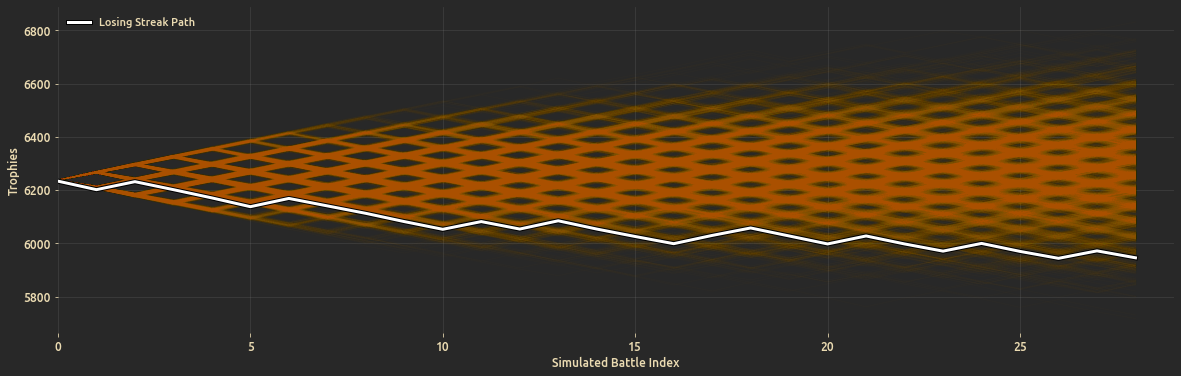

In [129]:
plt.plot(
    np.arange(0, simulated_trophies.shape[1]), 
    simulated_trophies.T, 
    color='orange', 
    alpha=0.01
)

(lose_streak_df.team_starting_trophies + lose_streak_df.team_trophy_change).reset_index(drop=True).plot(
    kind='line', color='white', label='Losing Streak Path', lw=3,
    path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()],
    figsize=(20, 6)
)

# add orange line label to legend
plt.legend(loc='upper left', frameon=True, fontsize=11)

# hide top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# show grid
plt.grid(which='major', axis='x', linestyle='-', color='grey', alpha=0.25)
plt.grid(which='major', axis='y', linestyle='-', color='grey', alpha=0.25)


plt.xlabel('Simulated Battle Index', fontweight='bold', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0, len(lose_streak_df)])
plt.ylabel('Trophies', fontweight='bold', fontsize=12);

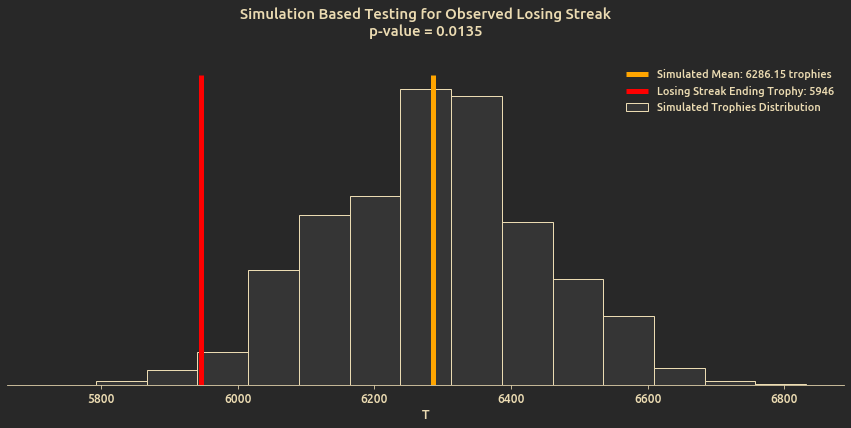

In [121]:
_ = plt.figure(figsize=(15, 6))
ax = sns.histplot(
    simulated_trophies[:,-1], 
    bins=15, 
    label='Simulated Trophies Distribution', 
    alpha=0.15, 
    color='gray'
)

max_y = ax.get_ylim()[1]

mean = np.mean(simulated_trophies[:,-1])
pval = np.count_nonzero(simulated_trophies[:,-1] < streak_ending_trophy) / simulated_trophies.shape[0]

ax.vlines(mean, 0, max_y,label=f'Simulated Mean: {mean:.2f} trophies', linewidth=5, color='orange')
ax.vlines(streak_ending_trophy, 0, max_y, label=f'Losing Streak Ending Trophy: {streak_ending_trophy}', linewidth=5, color='red')
ax.set_xlabel('T', fontsize=13)
ax.tick_params(axis='x', labelsize=12)

ax.set_title(f'Simulation Based Testing for Observed Losing Streak\np-value = {pval:.4f}\n', fontsize=15)


# Turn off spines in all subplots
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_ylabel('')
ax.set_yticks([])
ax.legend(fontsize=11)

ax.legend(loc='upper right', fontsize=11);